# Colour - HDRI - Examples: Merge from Raw Files with Post Demosaicing

Through this example, some Canon EOS 5D Mark II *CR2* files will be merged together prior to demosaicing in order to create a single radiance image.

> Note: The final result exhibits a magenta cast, we haven't investigated the exact origin yet.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate non demosaiced linear *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- Creation of an image stack using *DNG* and intermediate *Tiff* files:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
- Merging of the image stack into a radiance image.
- White balancing of the radiance image.
- Demosaicing of the radiance image.
- Conversion of the radiance image to *RGB* display colourspace.
- Display of the final resulting radiance image.

> Note: Some steps can be performed using alternative methods or simplified, for instance the *DNG* conversion can be entirely avoided. Our interest here is to retrieve the camera levels and the [Adobe DNG](https://helpx.adobe.com/photoshop/digital-negative.html) camera colour profiling data.

## CR2 Files Conversion to DNG and Intermediate Files

In [1]:
% matplotlib inline

In [2]:
import logging
import numpy as np
import os

import colour
from colour.plotting import *
from colour_demosaicing import (
    demosaicing_CFA_Bayer_DDFAPD,
    masks_CFA_Bayer)

from colour_hdri import (
    Image,
    ImageStack,
    camera_space_to_sRGB,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_exif_tag,
    linear_conversion,
    image_stack_to_radiance_image,
    radiance_image_strip_plot,
    update_exif_tags,
    weighting_function_Debevec1997)

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OECF = colour.RGB_COLOURSPACES['sRGB'].OECF

RESOURCES_DIRECTORY = os.path.join(os.getcwd(),
                                   '..',
                                   'resources',
                                   'colour-hdri-examples-dataset',
                                   'frobisher_001')

In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=False)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

XYZ_TO_CAMERA_MATRIX = np.asarray(
    map(float, read_exif_tag(DNG_FILES[-2],
                         'ColorMatrix2').split())).reshape((3, 3))

INFO:colour_hdri.process.conversion:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng" file.
INFO:colour_hdri.process.conversion:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.dng" file.
INFO:colour_hdri.process.conversion:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Devel

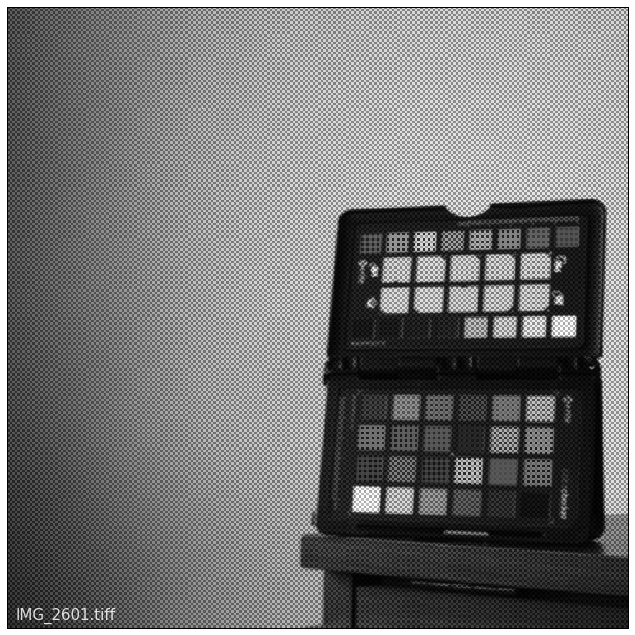

True

In [4]:
image_plot(OECF(colour.read_image(
            str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           os.path.basename(INTERMEDIATE_FILES[-2]))

## Radiance Image Merge and Demosaicing

In [5]:
def merge_from_raw_files_with_post_demosaicing(
        dng_files,
        output_directory,
        batch_size=5,
        black_level=None,
        white_level=None,
        white_balance_multipliers=None,
        weighting_function=weighting_function_Debevec1997,
        CFA_pattern='RGGB'):
    for dng_files in colour.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace('dng', 'tiff'))
            image.read_data()
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            '{0}_{1}_MRFPD.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))

        LOGGER.info('Scaling "{0}"...'.format(', '.join(
            image_stack.path)))
        black_level_e = (0 if
                         image_stack.black_level[0] is None else
                         np.average(image_stack.black_level[0]))
        white_level_e = image_stack.white_level[0]
        LOGGER.info('\tBlack Level (Exif): {0}'.format(
            black_level_e))
        LOGGER.info('\tWhite Level (Exif): {0}'.format(
            white_level_e))
        black_level = black_level if black_level is not None else black_level_e
        white_level = white_level if white_level is not None else white_level_e
        LOGGER.info('\tBlack Level (Used): {0}'.format(
            black_level))
        LOGGER.info('\tWhite Level (Used): {0}'.format(
            white_level))
        image_stack.data = linear_conversion(
            image_stack.data, (black_level, white_level), (0, 1))

        LOGGER.info('Merging "{0}"...'.format(path))
        LOGGER.info('\tImage stack "F Number" (Exif): {0}'.format(
            image_stack.f_number))
        LOGGER.info('\tImage stack "Exposure Time" (Exif): {0}'.format(
            image_stack.exposure_time))
        LOGGER.info('\tImage stack "ISO" (Exif): {0}'.format(
            image_stack.iso))
        image = image_stack_to_radiance_image(image_stack, weighting_function)
        image[np.isnan(image)] = 0

        LOGGER.info('White Balancing "{0}"...'.format(path))
        white_balance_multipliers_e = np.power(
            image_stack.white_balance_multipliers[0], -1)
        LOGGER.info('\tWhite Balance Multipliers (Exif): {0}'.format(
            white_balance_multipliers_e))
        white_balance_multipliers = (white_balance_multipliers
                                     if white_balance_multipliers is not None
                                     else white_balance_multipliers_e)
        LOGGER.info('\tWhite Balance Multipliers (Used): {0}'.format(
            white_balance_multipliers))
        # For consistency and comparison ease with 
        # *Colour - HDRI - Example: Merge from Raw Files* example, the 
        # white balance multipliers are not normalised here too.
        # white_balance_multipliers /= np.max(white_balance_multipliers)
        R_m, G_m, B_m = masks_CFA_Bayer(image.shape, CFA_pattern)
        image[R_m] *= white_balance_multipliers[0]
        image[G_m] *= white_balance_multipliers[1]
        image[B_m] *= white_balance_multipliers[2]

        LOGGER.info('Demosaicing "{0}"...'.format(path))
        image = demosaicing_CFA_Bayer_DDFAPD(image, CFA_pattern)

        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

        return image, path


IMAGE, PATH = merge_from_raw_files_with_post_demosaicing(
    DNG_FILES, RESOURCES_DIRECTORY)

INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.dng' image exif data.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2598.tiff" image.
INFO:colour_hdri.utilities.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-hdri-examples-dataset/frobisher_001/IMG_2599.dng" image metadata.
INFO:colour_hdri.utilities.exif:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/../resources/colour-

## Camera Space to sRGB Colourspace Conversion and Radiance Image Display

/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour/models/dataset/srgb.py:117: RuntimeWarning: invalid value encountered in power
  1.055 * (value ** (1 / 2.4)) - 0.055)


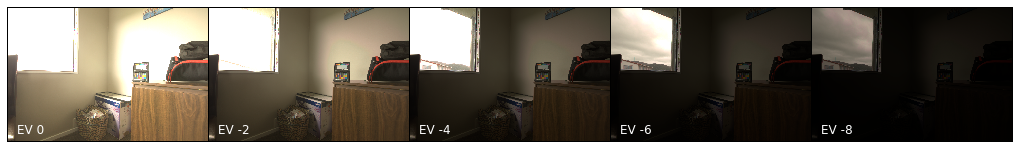

True

In [6]:
IMAGE_sRGB = camera_space_to_sRGB(IMAGE, XYZ_TO_CAMERA_MATRIX)

colour.write_image(IMAGE_sRGB, PATH.replace('.exr', '_sRGB.exr'))

radiance_image_strip_plot(IMAGE_sRGB)